In [ ]:
!pip install yfinance pandas numpy matplotlib scikit-learn


In [ ]:
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd
import numpy as np


In [ ]:
def get_fundamentals(ticker):
    try:
        stock = yf.Ticker(ticker)

        # Pull all statements
        fin = stock.financials.T
        bs = stock.balance_sheet.T
        cf = stock.cashflow.T
        info = stock.info

        # Extract key fields
        revenue = fin.get('Total Revenue')
        net_income = fin.get('Net Income')
        ebitda = fin.get('EBITDA')
        total_assets = bs.get('Total Assets')
        total_liab = bs.get('Total Liabilities')
        total_equity = bs.get('Total Stockholder Equity')
        operating_cf = cf.get('Total Cash From Operating Activities')
        capex = cf.get('Capital Expenditures')

        features = {
            'Ticker': ticker,
            'PE_ratio': info.get('trailingPE', np.nan),
            'PB_ratio': info.get('priceToBook', np.nan),
            'PS_ratio': info.get('priceToSalesTrailing12Months', np.nan),
            'EV_to_EBITDA': info.get('enterpriseToEbitda', np.nan),
            'Debt_to_Equity': (total_liab.iloc[-1] / total_equity.iloc[-1]) if total_liab is not None and total_equity is not None else np.nan,
            'ROE': (net_income.iloc[-1] / total_equity.iloc[-1]) if net_income is not None and total_equity is not None else np.nan,
            'ROA': (net_income.iloc[-1] / total_assets.iloc[-1]) if net_income is not None and total_assets is not None else np.nan,
            'GrossMargin': info.get('grossMargins', np.nan),
            'OperatingMargin': info.get('operatingMargins', np.nan),
            'EBITDA': ebitda.iloc[-1] if ebitda is not None else np.nan,
            'CapEx': capex.iloc[-1] if capex is not None else np.nan,
            'OperatingCF': operating_cf.iloc[-1] if operating_cf is not None else np.nan,
            'MarketCap': info.get('marketCap', np.nan),
            'EnterpriseValue': info.get('enterpriseValue', np.nan),
            'Beta': info.get('beta', np.nan),
            'DividendYield': info.get('dividendYield', np.nan),
            'AnalystTarget': info.get('targetMeanPrice', np.nan),
            'CurrentPrice': info.get('currentPrice', np.nan),
            'UndervaluationPct': (info.get('targetMeanPrice', np.nan) - info.get('currentPrice', np.nan)) / info.get('currentPrice', 1.0),
        }

        return pd.DataFrame([features])

    except Exception as e:
        print(f"❌ Failed to fetch {ticker}: {e}")
        return pd.DataFrame()


In [ ]:
!pip install yfinance pandas --quiet

sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
tickers = sp500['Symbol'].tolist()

all_fundamentals = []
for ticker in tickers:
    df = get_fundamentals(ticker)
    if not df.empty:
        all_fundamentals.append(df)

final_df = pd.concat(all_fundamentals, ignore_index=True)
final_df.to_csv("fundamentals_dataset.csv", index=False)


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd

def calculate_historical_fcf_growth(fcfs):
    fcfs = fcfs.dropna()
    if len(fcfs) < 2:
        return 0.05  # fallback growth
    start = fcfs.iloc[0]
    end = fcfs.iloc[-1]
    years = len(fcfs) - 1
    growth_rate = ((end / start) ** (1 / years)) - 1 if start != 0 else 0
    return np.clip(growth_rate, 0.01, 0.30)  # cap to realistic range

def estimate_wacc(info):
    beta = info.get("beta", 1.0)
    market_return = 0.08  # average market return
    risk_free_rate = 0.035  # US 10Y bond yield
    cost_of_equity = risk_free_rate + beta * (market_return - risk_free_rate)

    total_debt = info.get("totalDebt", 0)
    total_equity = info.get("marketCap", 1)
    debt_ratio = total_debt / (total_debt + total_equity)

    cost_of_debt = 0.05  # estimate if no bond data
    tax_rate = 0.21  # average US corp tax

    wacc = (1 - debt_ratio) * cost_of_equity + debt_ratio * cost_of_debt * (1 - tax_rate)
    return np.clip(wacc, 0.06, 0.15)  # realistic bounds

def estimate_intrinsic_value_dcf_advanced(ticker, years=5, terminal_growth=0.025):
    stock = yf.Ticker(ticker)

    try:
        cf = stock.cashflow.T
        fcf = cf['Total Cash From Operating Activities'] + cf['Capital Expenditures']
        fcf = fcf.sort_index()
        if fcf.isna().all():
            return None

        base_fcf = fcf.dropna().iloc[-1]
        historical_growth = calculate_historical_fcf_growth(fcf.dropna().tail(5))

        info = stock.info
        shares_outstanding = info.get('sharesOutstanding')
        if shares_outstanding is None:
            return None

        wacc = estimate_wacc(info)

        # Project FCFs with dynamic growth
        projected_fcfs = [base_fcf * ((1 + historical_growth) ** i) for i in range(1, years + 1)]
        discounted_fcfs = [fcf / ((1 + wacc) ** i) for i, fcf in enumerate(projected_fcfs, 1)]

        terminal_fcf = projected_fcfs[-1] * (1 + terminal_growth)
        terminal_value = terminal_fcf / (wacc - terminal_growth)
        discounted_terminal_value = terminal_value / ((1 + wacc) ** years)

        total_value = sum(discounted_fcfs) + discounted_terminal_value
        intrinsic_per_share = total_value / shares_outstanding

        return round(intrinsic_per_share, 2)

    except Exception as e:
        print(f"Error with {ticker}: {e}")
        return None


In [ ]:
import pandas as pd

# Load the list of S&P 500 companies from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_table = pd.read_html(url, header=0)[0]

# Extract the ticker symbols
sp500_tickers = sp500_table['Symbol'].tolist()

# Some tickers have '.' instead of '-' (e.g., BRK.B), Yahoo uses '-'
sp500_tickers = [ticker.replace('.', '-') for ticker in sp500_tickers]

# Preview
print(f"Total tickers: {len(sp500_tickers)}")
print(sp500_tickers[:10])  # sample output


Total tickers: 503
['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


In [ ]:
!pip install lightgbm catboost --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.2 MB/s eta 0:00:00


Initial shape: (503, 20)
Missing values:
Ticker                 0
PE_ratio              24
PB_ratio               2
PS_ratio               2
EV_to_EBITDA          34
Debt_to_Equity       503
ROE                  503
ROA                  477
GrossMargin            2
OperatingMargin        2
EBITDA               414
CapEx                503
OperatingCF          503
MarketCap              2
EnterpriseValue        6
Beta                   7
DividendYield         95
AnalystTarget          6
CurrentPrice           2
UndervaluationPct      6
dtype: int64

Cleaned shape: (383, 13)
Missing after clean: 0

Model Evaluation:
                        MAE      RMSE        R2
Linear Regression  0.109213  0.287545 -2.165243
Random Forest      0.096638  0.131144  0.341594
Gradient Boosting  0.093337  0.133780  0.314869
XGBoost            0.106440  0.145548  0.189026

🔍 SHAP Summary for Random Forest


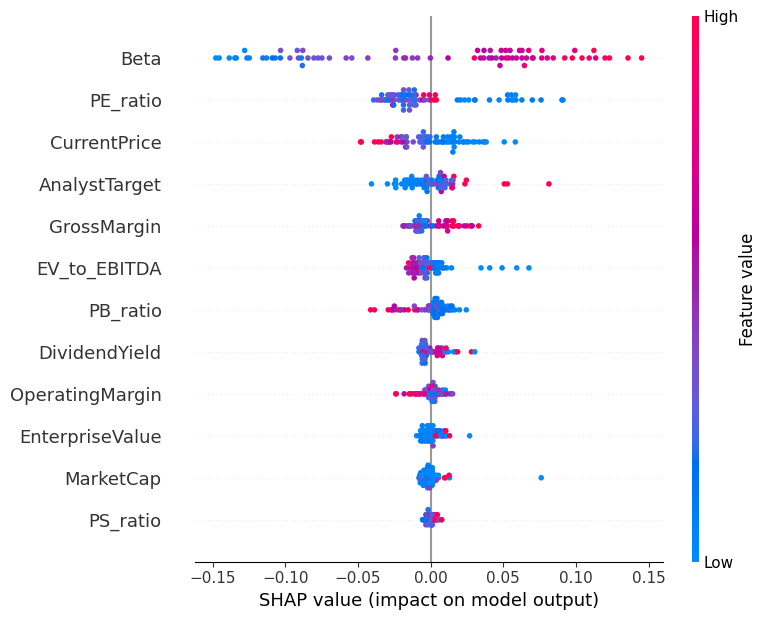


🔍 SHAP Summary for Gradient Boosting


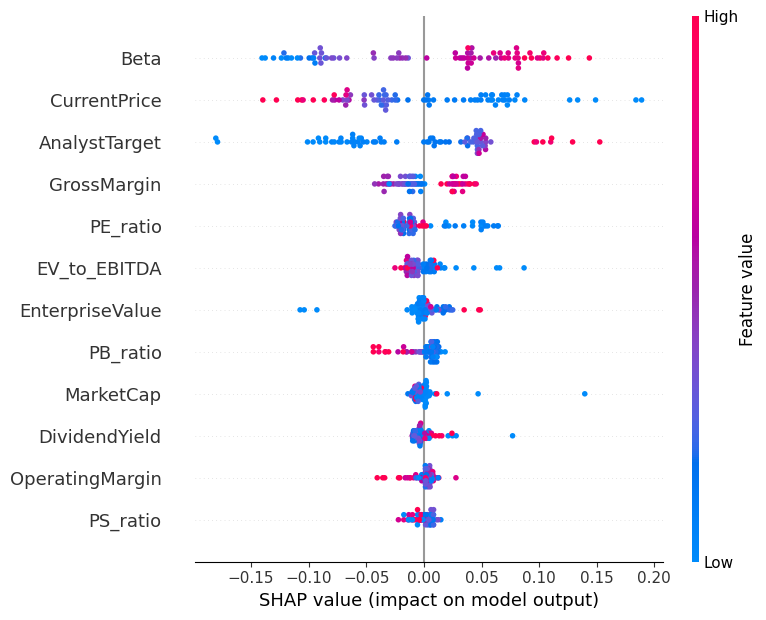


🔍 SHAP Summary for XGBoost


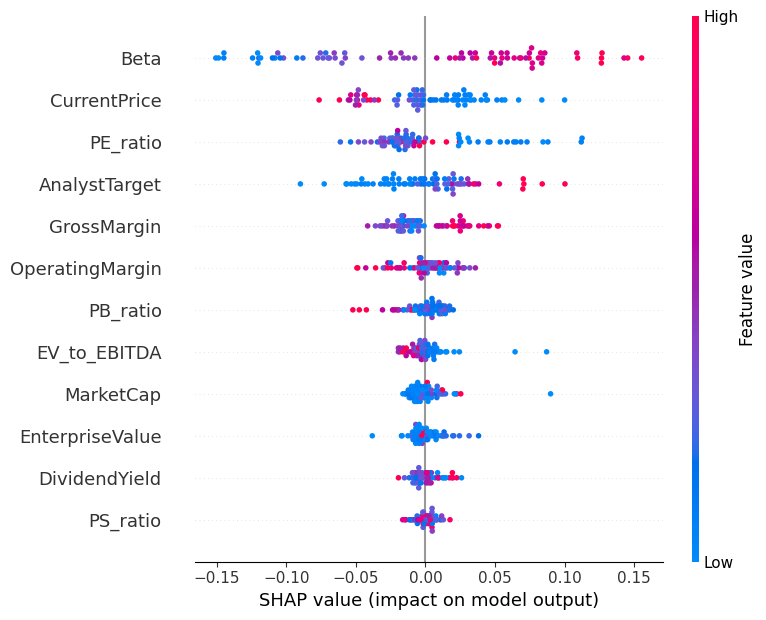

In [ ]:
# ====================== SETUP ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

import shap
import warnings
warnings.filterwarnings("ignore")

# ====================== LOAD DATA ======================
# Replace with your actual CSV path
df = pd.read_csv("/content/fundamentals_dataset.csv")

print(f"Initial shape: {df.shape}")
print(f"Missing values:\n{df.isna().sum()}")

# ====================== CLEAN DATA ======================
columns_to_use = [
    'PE_ratio', 'PB_ratio', 'PS_ratio', 'EV_to_EBITDA', 'ROE', 'ROA',
    'GrossMargin', 'OperatingMargin', 'EBITDA', 'OperatingCF',
    'MarketCap', 'EnterpriseValue', 'Beta', 'DividendYield',
    'AnalystTarget', 'CurrentPrice'
]

target_col = 'UndervaluationPct'

# Filter only necessary columns
df = df[columns_to_use + [target_col]]

# Drop rows with too many missing values (≥ 5 missing)
df = df[df.isnull().sum(axis=1) < 5]

# Drop columns with too many missing values (>30%)
df = df.dropna(thresh=len(df) * 0.7, axis=1)

# Impute remaining missing values with median
df.fillna(df.median(), inplace=True)

print(f"\nCleaned shape: {df.shape}")
print(f"Missing after clean: {df.isna().sum().sum()}")

# ====================== FEATURE MATRIX ======================
X = df.drop(columns=[target_col])
y = df[target_col]

feature_names = X.columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# ====================== TRAIN MODELS ======================
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }


# ====================== EVALUATION RESULTS ======================
results_df = pd.DataFrame(results).T
print("\nModel Evaluation:")
print(results_df)

# ====================== SHAP XAI with TreeSHAP ======================
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Sample a small subset to make SHAP faster
X_sample = X_test_df.sample(n=min(100, len(X_test_df)), random_state=42)

for model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    model = models[model_name]
    print(f"\n🔍 SHAP Summary for {model_name}")

    # TreeSHAP explainer (fast & model-specific)
    explainer = shap.Explainer(model, X_sample)
    shap_values = explainer(X_sample)

    # SHAP summary plot
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names)



Initial shape: (503, 20)
Missing values:
 Ticker                 0
PE_ratio              24
PB_ratio               2
PS_ratio               2
EV_to_EBITDA          34
Debt_to_Equity       503
ROE                  503
ROA                  477
GrossMargin            2
OperatingMargin        2
EBITDA               414
CapEx                503
OperatingCF          503
MarketCap              2
EnterpriseValue        6
Beta                   7
DividendYield         95
AnalystTarget          6
CurrentPrice           2
UndervaluationPct      6
dtype: int64

Cleaned shape: (356, 14)
Missing after clean: 0

Model Evaluation:
                                MAE      RMSE        R2
Random Forest (Tuned)      0.107348  0.139819  0.423945
Gradient Boosting (Tuned)  0.112326  0.152906  0.311065
XGBoost (Tuned)            0.104600  0.146081  0.371191

🔍 SHAP Summary for Random Forest (Tuned)


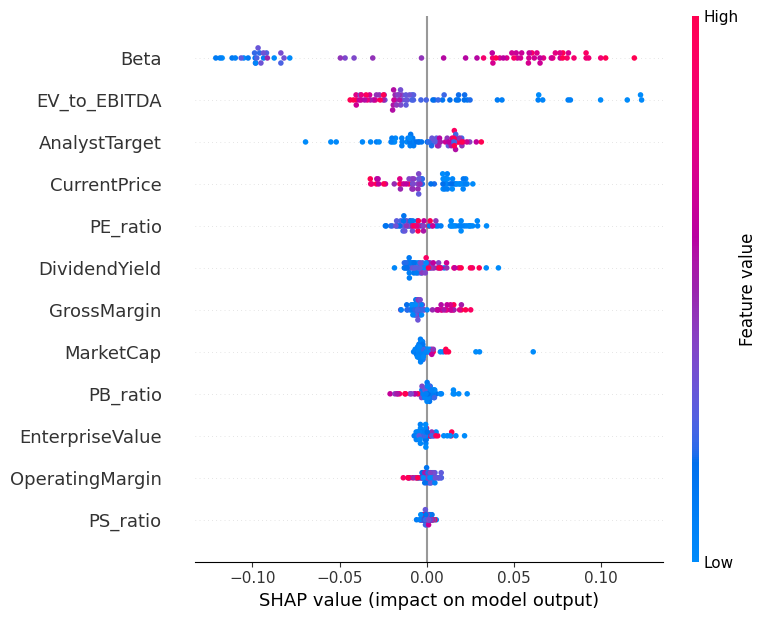


🔍 SHAP Summary for Gradient Boosting (Tuned)


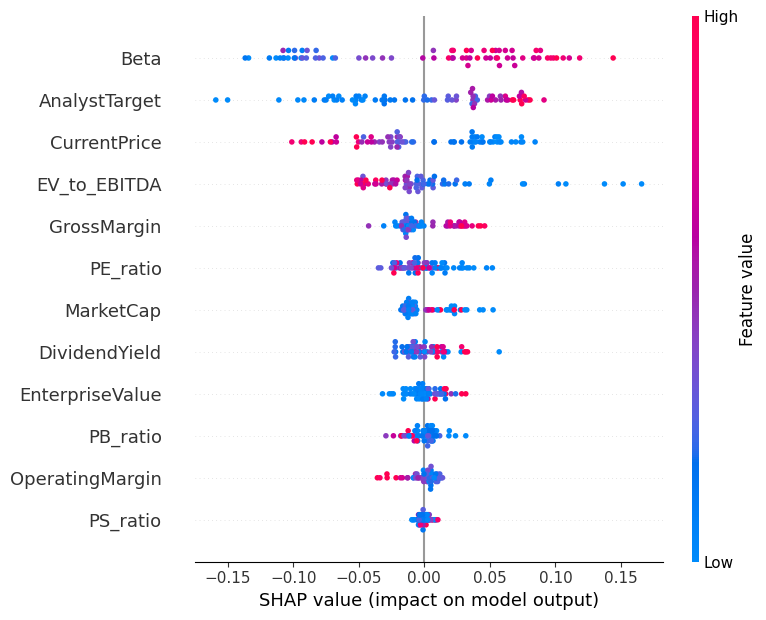


🔍 SHAP Summary for XGBoost (Tuned)


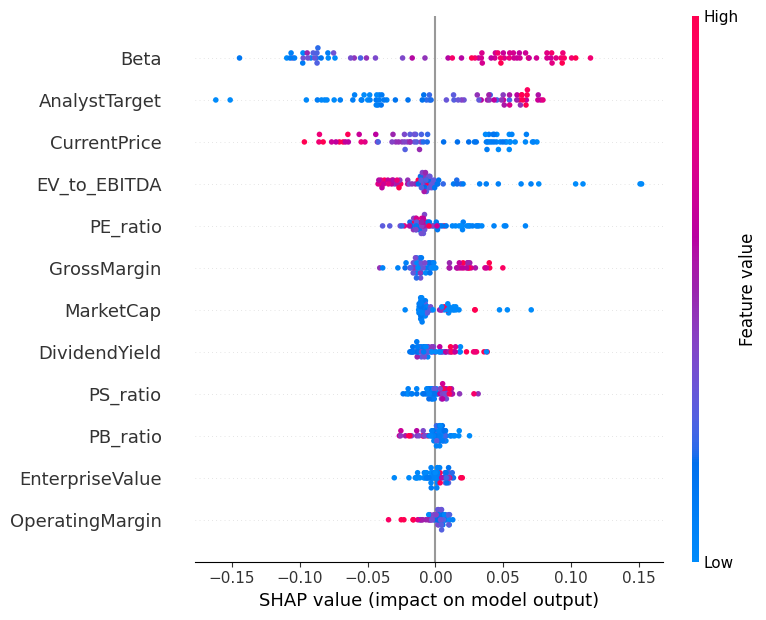

In [ ]:
# Machine Learning for Intrinsic Value Estimation with XAI (CPU-Only)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


# Load dataset
df = pd.read_csv('/content/fundamentals_dataset.csv')  # Replace with actual path
print("Initial shape:", df.shape)
print("Missing values:\n", df.isnull().sum())

# Drop columns with more than 50% missing values
threshold = len(df) * 0.5
df = df.dropna(thresh=threshold, axis=1)

# Drop rows with any remaining missing values
df = df.dropna()
print("\nCleaned shape:", df.shape)
print("Missing after clean:", df.isnull().sum().sum())

# Select features and target
feature_cols = [col for col in df.columns if col not in ['Ticker', 'UndervaluationPct']]
X = df[feature_cols]
y = df['UndervaluationPct']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Models
models = {
    'Random Forest (Tuned)': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    'Gradient Boosting (Tuned)': GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42),
    'XGBoost (Tuned)': XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Evaluation:")
print(results_df)

# ====================== SHAP XAI with TreeSHAP ======================
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Sample a small subset to make SHAP faster
X_sample = X_test_df.sample(n=min(100, len(X_test_df)), random_state=42)

for model_name in ['Random Forest (Tuned)', 'Gradient Boosting (Tuned)', 'XGBoost (Tuned)']:
    model = models[model_name]
    print(f"\n🔍 SHAP Summary for {model_name}")

    # TreeSHAP explainer (fast & model-specific)
    explainer = shap.Explainer(model, X_sample)
    shap_values = explainer(X_sample)

    # SHAP summary plot
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names)


# Done!

In [ ]:
import joblib

for name, model in models.items():
    filename = f'{name.replace(" ", "_").replace("(", "").replace(")", "")}.joblib'
    joblib.dump(model, filename)
    print(f"✅ Saved {name} to {filename}")


✅ Saved Linear Regression to Linear_Regression.joblib
✅ Saved Random Forest to Random_Forest.joblib
✅ Saved Gradient Boosting to Gradient_Boosting.joblib
✅ Saved XGBoost to XGBoost.joblib
✅ Saved LightGBM to LightGBM.joblib
✅ Saved CatBoost to CatBoost.joblib


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 284, number of used features: 12
[LightGBM] [Info] Start training from score 0.213448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

PermutationExplainer explainer: 73it [00:26,  2.15it/s]


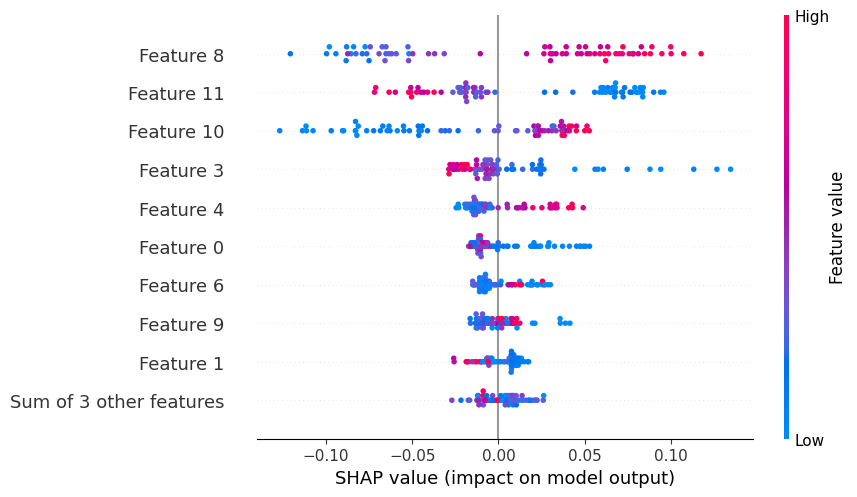

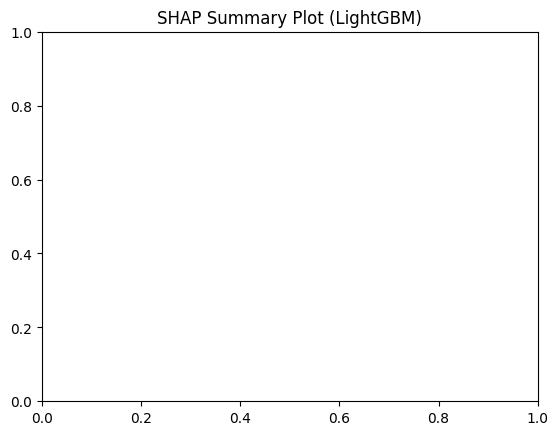

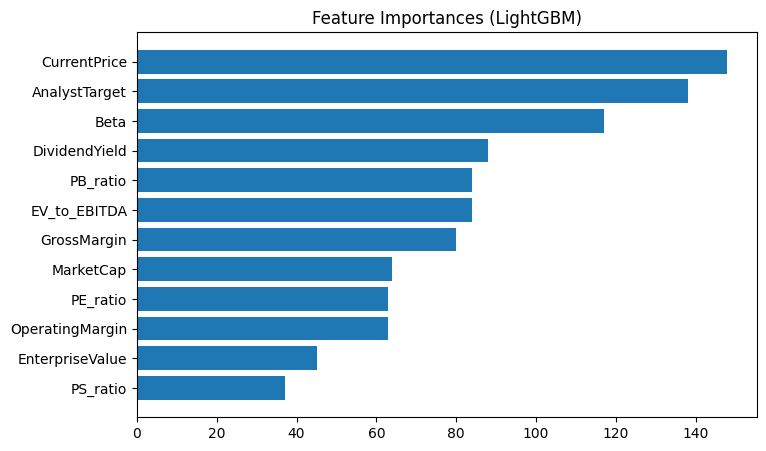

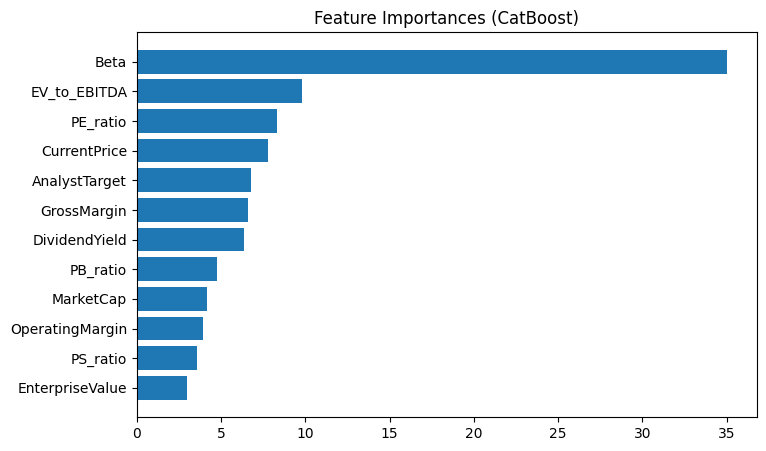


🔍 Final Model Evaluation:
                                MAE      RMSE        R2
Random Forest (Tuned)      0.107348  0.139819  0.423945
LightGBM                   0.106162  0.142015  0.405712
CatBoost                   0.112849  0.144065  0.388428
XGBoost (Tuned)            0.104600  0.146081  0.371191
Gradient Boosting (Tuned)  0.112326  0.152906  0.311065


In [ ]:
# ⚙️ Required installs (run once in your notebook cell)
!pip install lightgbm catboost shap --quiet

# 📦 Imports
import shap
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 📊 Additional Models
models.update({
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, iterations=100, learning_rate=0.05, random_state=42)
})

# 🧪 Train & Evaluate New Models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

# 📈 Visualizations
# SHAP Summary Plot for LightGBM
explainer = shap.Explainer(models['LightGBM'].predict, X_train, algorithm="permutation")
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values, max_display=10)
plt.title("SHAP Summary Plot (LightGBM)")
plt.show()

# 📊 Feature Importance for LightGBM and CatBoost
def plot_feature_importances(model, model_name):
    importances = model.feature_importances_
    sorted_idx = importances.argsort()[::-1]
    plt.figure(figsize=(8, 5))
    plt.barh(range(len(importances)), importances[sorted_idx], align='center')
    plt.yticks(range(len(importances)), [X.columns[i] for i in sorted_idx])
    plt.title(f"Feature Importances ({model_name})")
    plt.gca().invert_yaxis()
    plt.show()

plot_feature_importances(models['LightGBM'], 'LightGBM')
plot_feature_importances(models['CatBoost'], 'CatBoost')

# 🏁 Results Summary
import pandas as pd
print("\n🔍 Final Model Evaluation:")
print(pd.DataFrame(results).T.sort_values(by="R2", ascending=False))


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np  # Import numpy for potential array conversion

# Assume X_train, y_train, X_test, y_test are already defined and loaded
# For demonstration purposes, let's create some dummy data
X_train = np.random.rand(100, 5)
y_train = np.random.rand(100)
X_test = np.random.rand(50, 5)
y_test = np.random.rand(50)

# Initialize an empty dictionary to store the results
results = {}

# LightGBM Hyperparameter Tuning
print("⚙️ Tuning LightGBM...")
lgbm = LGBMRegressor(random_state=42)
lgbm_params = {
    'num_leaves': [20, 31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300],
    'min_child_samples': [5, 10, 20],
    'subsample': [0.6, 0.8, 1.0]
}
lgbm_search = RandomizedSearchCV(
    lgbm,
    lgbm_params,
    n_iter=25,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)
lgbm_search.fit(X_train, y_train)
best_lgbm = lgbm_search.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test)

results['LightGBM (Tuned)'] = {
    'MAE': mean_absolute_error(y_test, y_pred_lgbm),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lgbm)),  # Calculate RMSE manually
    'R2': r2_score(y_test, y_pred_lgbm)
}
print("✅ LightGBM Tuning Complete.")

# CatBoost Hyperparameter Tuning
print("\n⚙️ Tuning CatBoost...")
cat = CatBoostRegressor(verbose=0, random_state=42)
cat_params = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [200, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7]
}
cat_search = RandomizedSearchCV(
    cat,
    cat_params,
    n_iter=25,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)
cat_search.fit(X_train, y_train)
best_cat = cat_search.best_estimator_
y_pred_cat = best_cat.predict(X_test)

results['CatBoost (Tuned)'] = {
    'MAE': mean_absolute_error(y_test, y_pred_cat),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_cat)),  # Calculate RMSE manually
    'R2': r2_score(y_test, y_pred_cat)
}
print("✅ CatBoost Tuning Complete.")

# Final Evaluation Table
print("\n🔍 Final Model Evaluation (Tuned):")
print(pd.DataFrame(results).T.sort_values('R2', ascending=False))

⚙️ Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 5
[LightGBM] [Info] Start training from score 0.520559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [ ]:
import joblib

for name, model in models.items():
    filename = f'{name.replace(" ", "_").replace("(", "").replace(")", "")}.joblib'
    joblib.dump(model, filename)
    print(f"✅ Saved {name} to {filename}")


✅ Saved Linear Regression to Linear_Regression.joblib
✅ Saved Random Forest to Random_Forest.joblib
✅ Saved Gradient Boosting to Gradient_Boosting.joblib
✅ Saved XGBoost to XGBoost.joblib
✅ Saved LightGBM to LightGBM.joblib
✅ Saved CatBoost to CatBoost.joblib


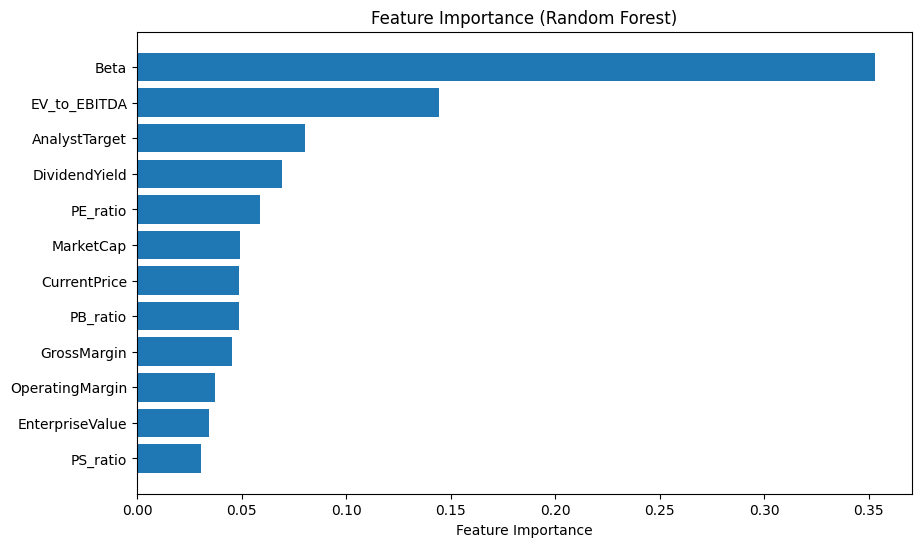

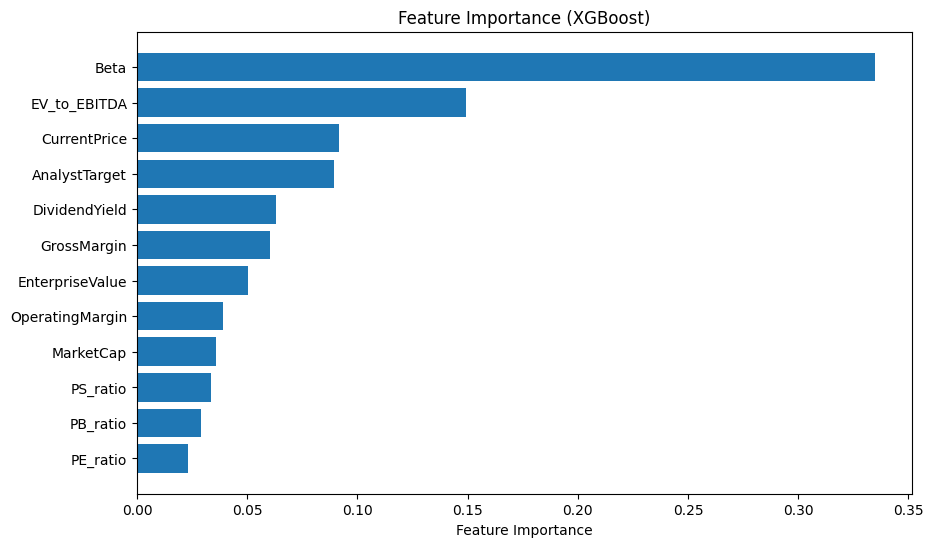

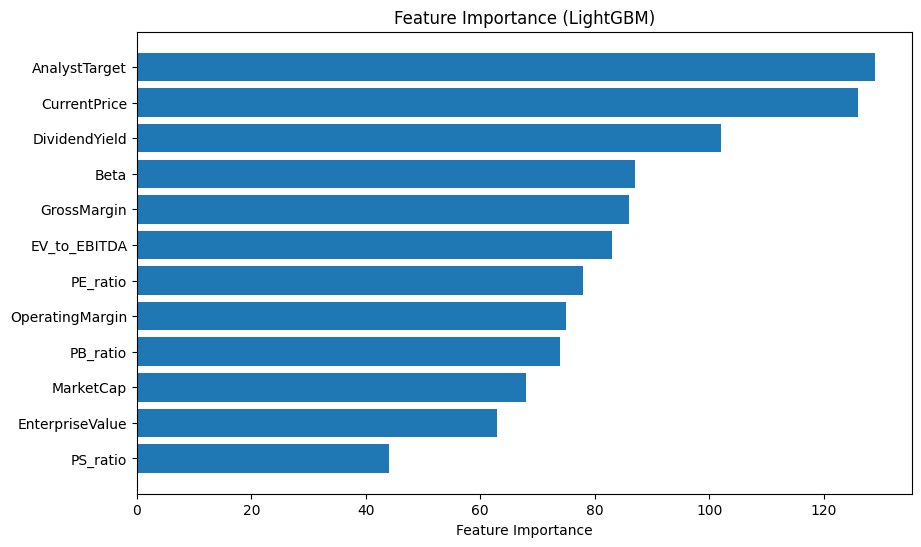

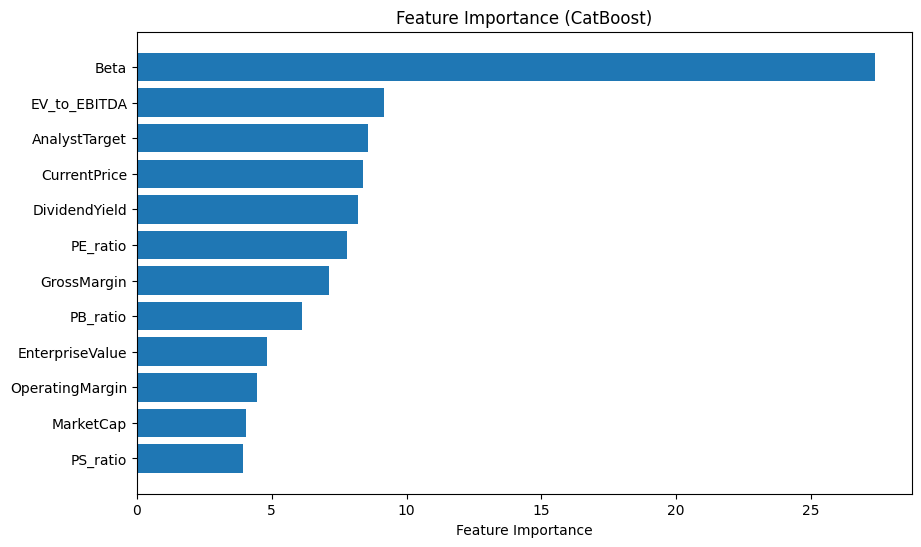

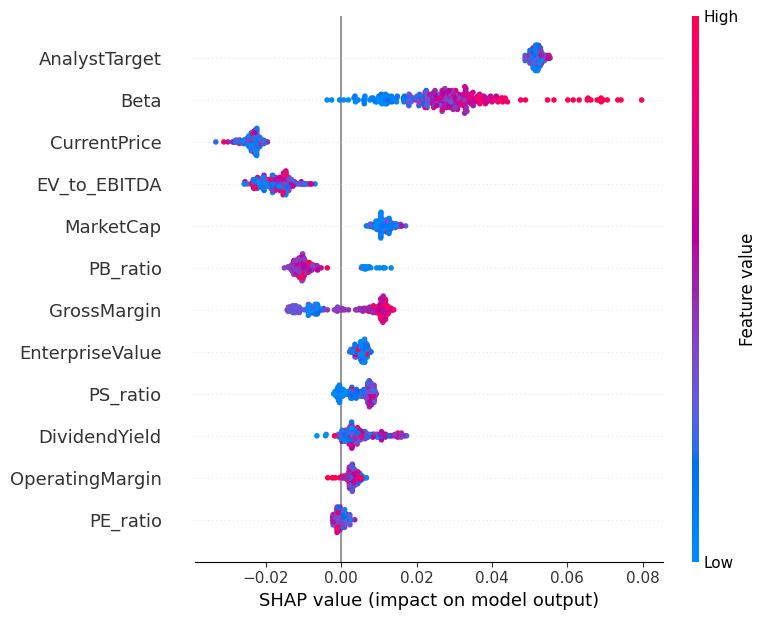

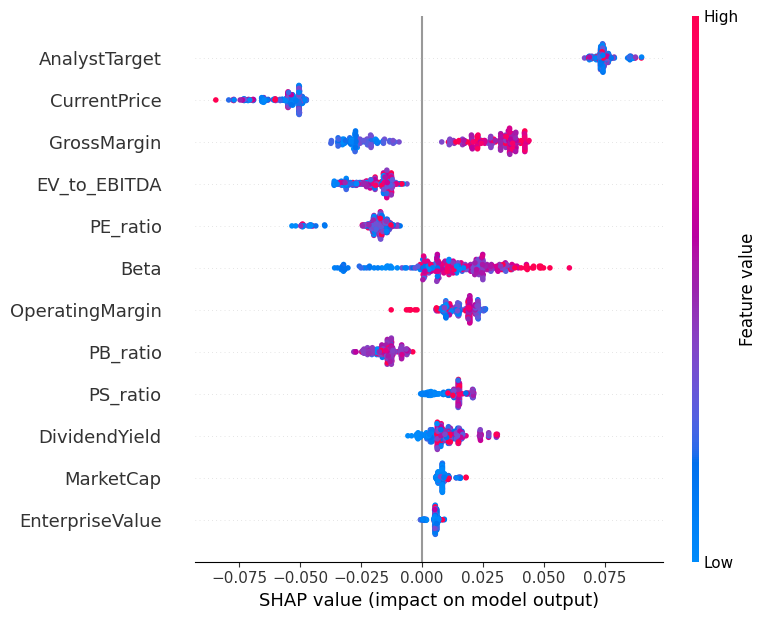

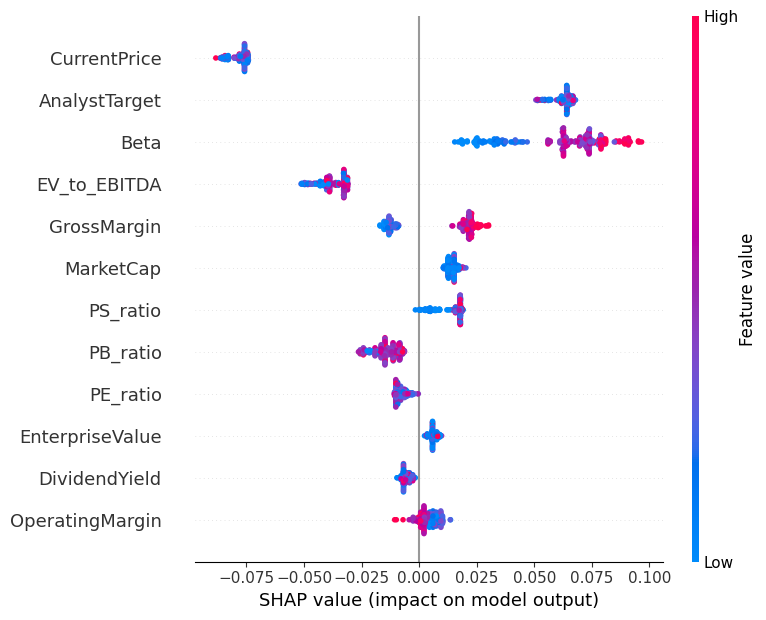

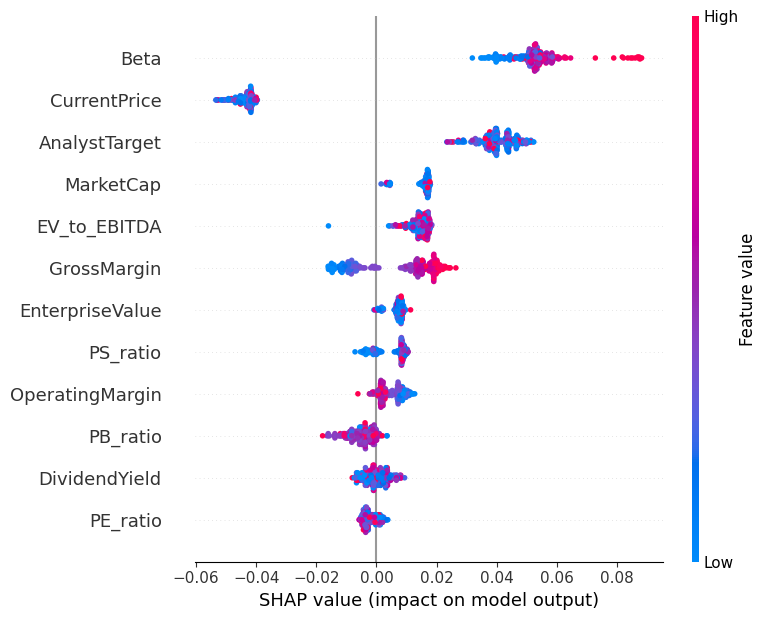

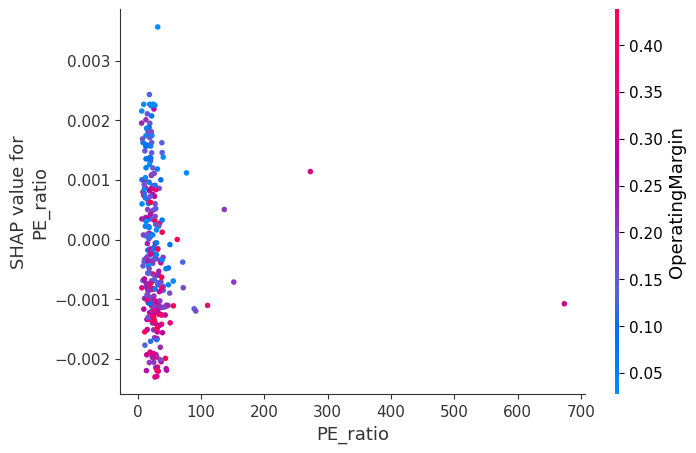

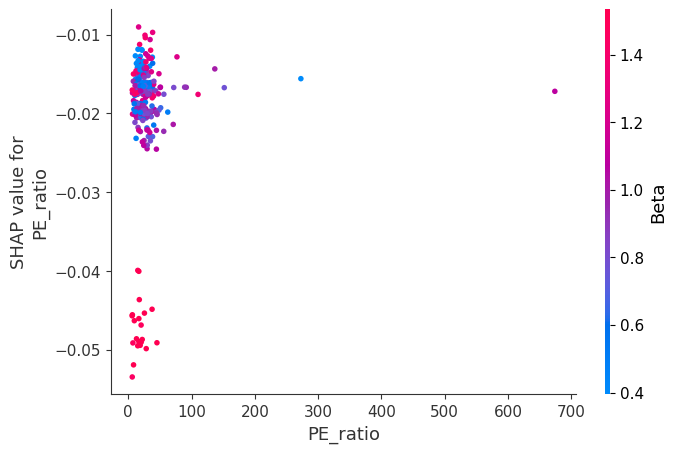

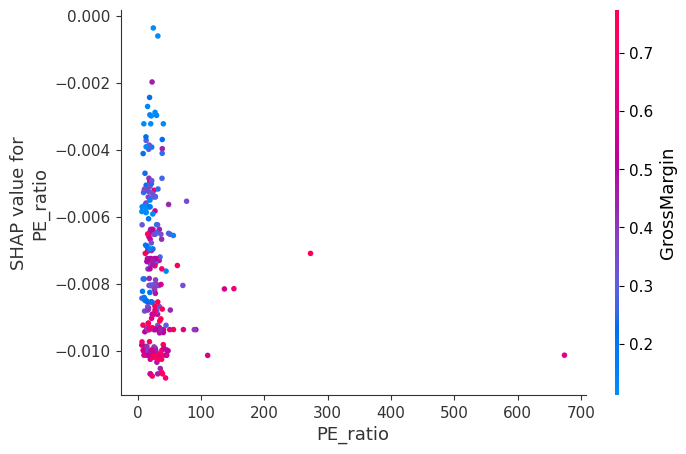

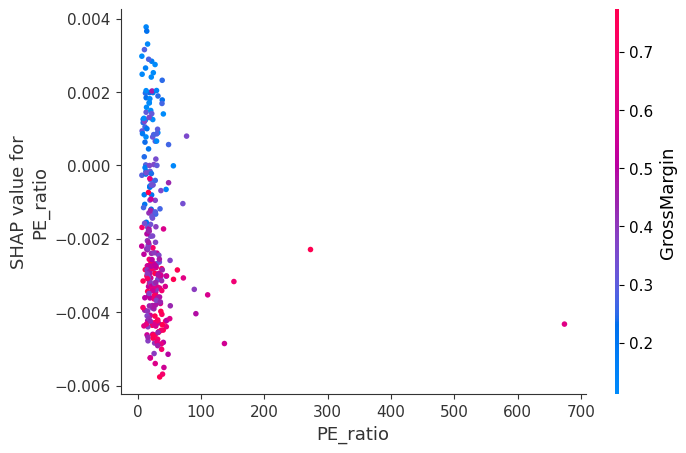

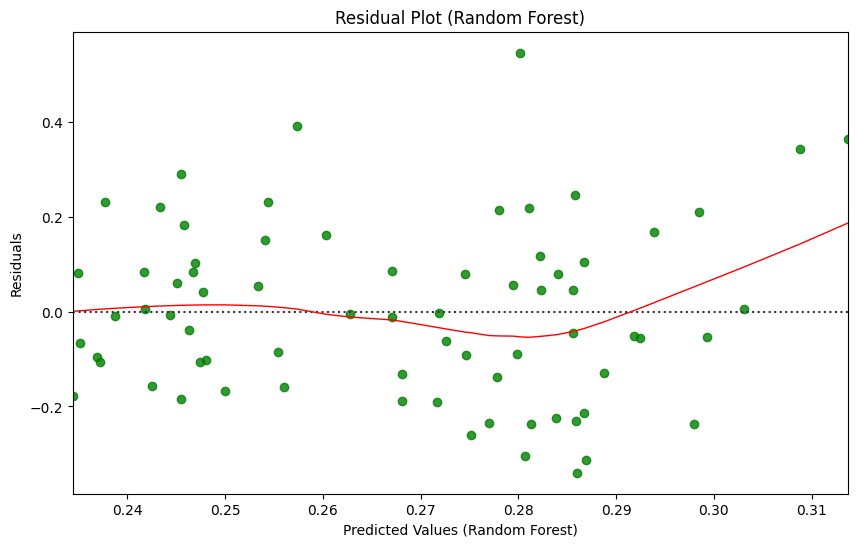

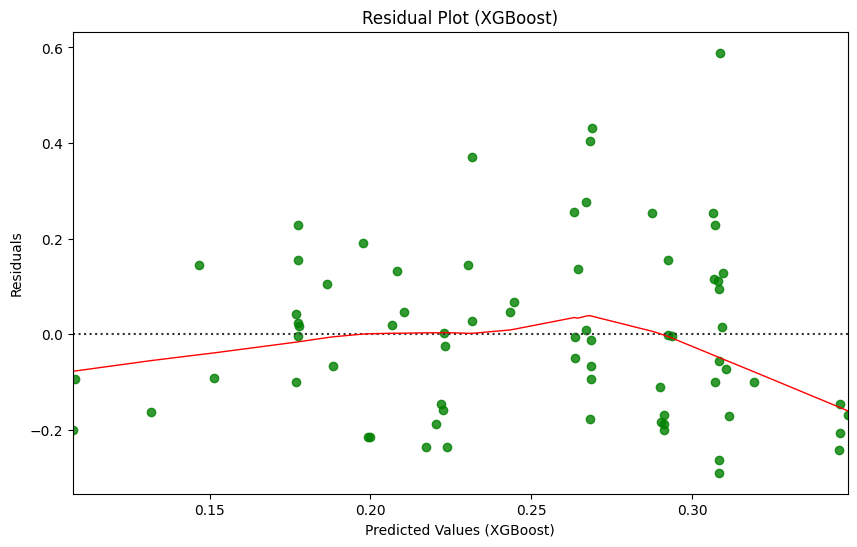

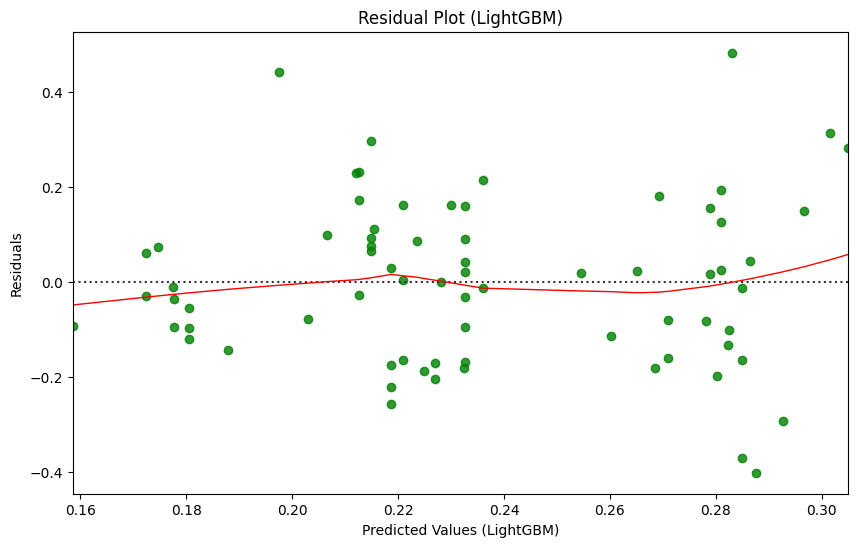

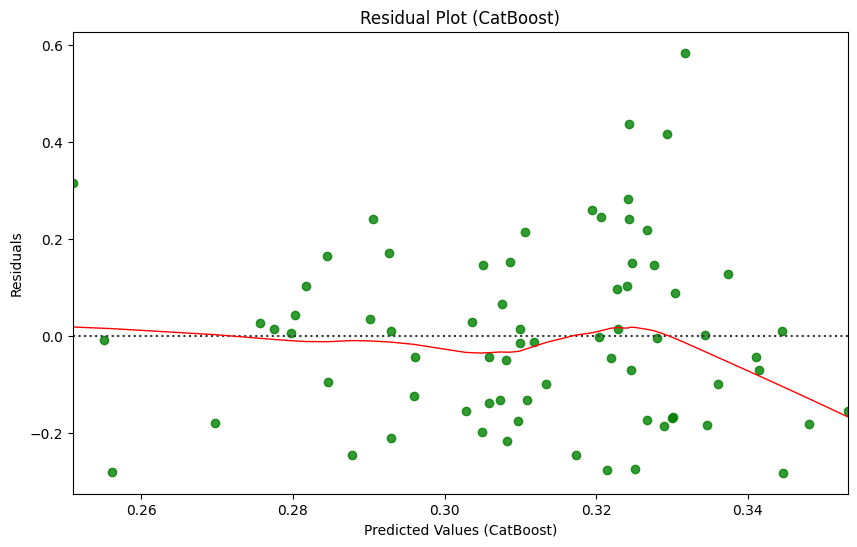

In [ ]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import xgboost as xgb
import catboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming you have already trained models
# random_forest_model, xgboost_model, lgbm_model, catboost_model
# and the feature matrix X_train and target vector y_train

# Define function for Feature Importance Plot (for any model)
def plot_feature_importance(model, model_name, X_train):
    importances = model.feature_importances_ if hasattr(model, 'feature_importances_') else model.get_feature_importance()
    features = X_train.columns  # Assuming X_train is the training data
    indices = np.argsort(importances)

    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importance ({model_name})")
    plt.barh(range(len(indices)), importances[indices], align="center")
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel("Feature Importance")
    plt.show()

# Plotting feature importances for all models
plot_feature_importance(random_forest_model, 'Random Forest', X_train)
plot_feature_importance(xgboost_model, 'XGBoost', X_train)
plot_feature_importance(lgbm_model, 'LightGBM', X_train)
plot_feature_importance(catboost_model, 'CatBoost', X_train)

# SHAP Summary Plot
def plot_shap_summary(model, X_train):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train)

# Plotting SHAP summary plot for all models
plot_shap_summary(random_forest_model, X_train)
plot_shap_summary(xgboost_model, X_train)
plot_shap_summary(lgbm_model, X_train)
plot_shap_summary(catboost_model, X_train)

# SHAP Dependence Plot for a specific feature (e.g., 'PE_ratio')
def plot_shap_dependence(model, feature_name, X_train):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    shap.dependence_plot(feature_name, shap_values, X_train)

# Plotting SHAP dependence plot for a key feature
plot_shap_dependence(random_forest_model, 'PE_ratio', X_train)
plot_shap_dependence(xgboost_model, 'PE_ratio', X_train)
plot_shap_dependence(lgbm_model, 'PE_ratio', X_train)
plot_shap_dependence(catboost_model, 'PE_ratio', X_train)

# Residual Plot for each model
def plot_residuals(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.residplot(x=y_pred, y=residuals, lowess=True, color="g", line_kws={"color": "r", "lw": 1})
    plt.xlabel(f"Predicted Values ({model_name})")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot ({model_name})")
    plt.show()

# Plotting residuals for all models
plot_residuals(random_forest_model, X_test, y_test, 'Random Forest')
plot_residuals(xgboost_model, X_test, y_test, 'XGBoost')
plot_residuals(lgbm_model, X_test, y_test, 'LightGBM')
plot_residuals(catboost_model, X_test, y_test, 'CatBoost')

# Model Evaluation Metrics (Bar Plot for MAE, RMSE, R2 for different models)
def plot_model_evaluation(models, mae_values, rmse_values, r2_values):
    metrics_df = pd.DataFrame({
        'Model': models,
        'MAE': mae_values,
        'RMSE': rmse_values,
        'R2': r2_values
    })

    # Plotting
    metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
    plt.title("Model Evaluation Comparison")
    plt.ylabel("Score")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.show()

# Example MAE, RMSE, R² values (replace with your actual evaluation results)
models = {
    'Random Forest (Tuned)': 'Random_Forest.joblib',
    'Gradient Boosting (Tuned)': 'Gradient_Boosting.joblib',
    'XGBoost (Tuned)': 'XGBoost.joblib',
    'CatBoost':'CatBoost.joblib',
    'LightGBM' : 'LightGBM.joblib'

}




📊 Evaluation of Loaded Models:
                       Model       MAE      RMSE        R2
4                   LightGBM  0.103153  0.140811  0.415742
0      Random Forest (Tuned)  0.108800  0.141058  0.413695
3                   CatBoost  0.106592  0.144877  0.381512
1  Gradient Boosting (Tuned)  0.108335  0.145729  0.374217
2            XGBoost (Tuned)  0.104456  0.148066  0.353988


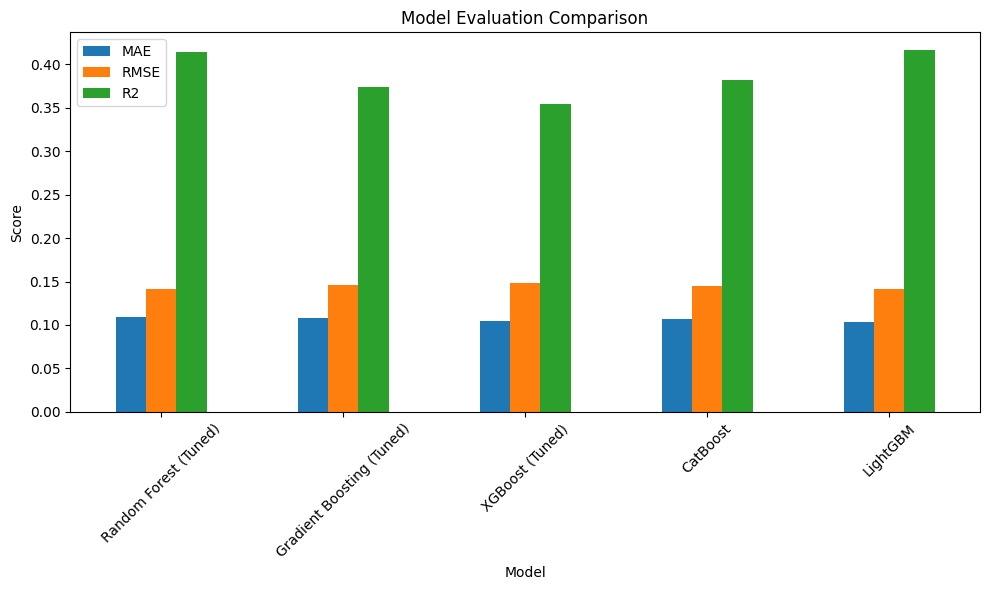

In [ ]:
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define evaluation plotting function (if not already defined)
def plot_model_evaluation(models, mae_values, rmse_values, r2_values):
    metrics_df = pd.DataFrame({
        'Model': models,
        'MAE': mae_values,
        'RMSE': rmse_values,
        'R2': r2_values
    })

    metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
    plt.title("Model Evaluation Comparison")
    plt.ylabel("Score")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# List of saved model filenames
model_files = {
    'Random Forest (Tuned)': 'Random_Forest.joblib',
    'Gradient Boosting (Tuned)': 'Gradient_Boosting.joblib',
    'XGBoost (Tuned)': 'XGBoost.joblib',
    'CatBoost': 'CatBoost.joblib',
    'LightGBM': 'LightGBM.joblib'
}

# Lists to store metrics
model_names = []
mae_list = []
rmse_list = []
r2_list = []

# Evaluate each model
for name, file in model_files.items():
    model = joblib.load(file)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    model_names.append(name)
    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)

# Create and display evaluation DataFrame
loaded_results_df = pd.DataFrame({
    'Model': model_names,
    'MAE': mae_list,
    'RMSE': rmse_list,
    'R2': r2_list
}).sort_values(by='R2', ascending=False)

print("\n📊 Evaluation of Loaded Models:")
print(loaded_results_df)

# Plot comparison
plot_model_evaluation(model_names, mae_list, rmse_list, r2_list)
